# Assignment 1 - Part 2

<div class="alert alert-block alert-warning">
    Below we import <a href="https://github.com/HIPS/autograd">autograd</a>. If you get an error saying you don't have it, you will need to install it with pip, using
<pre>
pip install autograd
</pre>
</div>

In [1]:
import  autograd.numpy as np
import matplotlib.pyplot as plt
from autograd import jacobian
import time as time
import tabulate as tab



## Newton's Method

We want to approximate solutions of nonlinear equation in __two variables__ using Newton's method.

Newton's method is implemented below.

Implement a stopping criterion. That is, given some tolerance $TOL$, end the method when $\mathbf{x}^k:=(x_1^k,x_2^k)$ satisfies $\|F(\mathbf{x}^k)\|_2\le TOL$ or $\|\mathbf{x}^{k+1}-\mathbf{x}^k\|_2\le TOL$.

Provide numerial evidence that your code works as it should by printing the values of $\|F(\mathbf{x}^k)\|_2$ for each iteration, and by making a plot of $\|F(\mathbf{x}^k)\|_2$, $\|\mathbf{x}^{k+1}-\mathbf{x}^k\|_2$, for all $k$.

Now, verify numerically the convergence is quadratic. You will need a reference solution, and one can do this in two ways:

 - Consider a problem for which you know an exact solution, and use said solution as a reference solution,
 - or for your problem, should you not know a solution, use the method to obtain an extremely accurate result which you use as a reference solution

In [2]:
def newtonsMethod(F, x0, maxIter, plotvar, TOL=1.0e-15):   #Array valued functions
    # Implementation of Newton's root finding method.
    # F - the function you wish to find the root for,
    # x0 - initial guess,
    # maxIter - maximum number of iterations.
    # For plotting of graphs, set plotvar = True, else; set plotvar to False
    DF = jacobian(F)
    x1 = x0
    
    norm_listFx = np.zeros(maxIter) #List storing norms of fx 
    norm_listDiff = np.zeros(maxIter) #List storing norms of ||x_k - x_{k+1}||
    iter_list = np.zeros(maxIter)  #List of number of iterations 0,1,2,...,maxiter    
    
    for n in range(0, maxIter):
        x0 = x1
        J = DF(x0)
        Fx = F(x0)
        x1 = x1 - np.linalg.solve(J,Fx)
        
        two_Fx = np.linalg.norm(Fx)  
        two_diff = np.linalg.norm(x1-x0)
        #print(two_Fx)
        
        norm_listFx[n]=two_Fx #storing 2 norm for F(x)
        norm_listDiff[n]=two_diff #storing 2 norm for difference of iterations 
        iter_list[n]=n
        
        if two_Fx<=TOL or two_diff<=TOL:
            print('Reached tolerance after',n,'iterations')
            maxIter = n
            break
    
    
    norm_listDiff = np.resize(norm_listDiff,maxIter)
    norm_listFx = np.resize(norm_listFx,maxIter)
    iter_list = np.resize(iter_list,maxIter)
    
    
    
    #Plotting the norms
    if plotvar == True:
        fig = plt.figure()
        ax = plt.subplot(111)
        ax.set(xlabel='Iteration number')
        ax.plot(iter_list,norm_listFx,label='$||F(x^k)||_2$') #Fx plot
        ax.plot(iter_list,norm_listDiff,label='$||x^k - x^{(k+1)}||_2$') #difference plot
        ax.legend()
        plt.grid()
    
        
    return x1

Reached tolerance after 8 iterations
[-0.92828469  1.41421356]


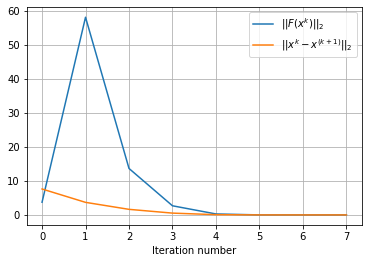

In [3]:

def test_func(q): #For some reason, the whole kernel needs to be restarted for test_func to work. g however, always works.
    x,y = q
    V = np.array([x**2-2*x -np.exp(1),y**2-2])
    return V

def g(r):
    return r**2 - 2

punkt=np.array([0.76,1.65],dtype=np.float_) 



sol = newtonsMethod(test_func,punkt,50,True)   
print(sol)


In [4]:
# Quadratic convergence



for l in range(0,8):
    firstSol =np.linalg.norm( newtonsMethod(g,punkt,l,False) )
    secondSol =np.linalg.norm( newtonsMethod(g,punkt,l+1,False) )
    
    print(secondSol/(firstSol**2))







0.67238170271397
0.4095890064826082
0.4918024078696237
0.49993280575289806
0.49999999548479496
Reached tolerance after 5 iterations
0.49999999999999994
Reached tolerance after 5 iterations
Reached tolerance after 5 iterations
0.5000000000000001
Reached tolerance after 5 iterations
Reached tolerance after 5 iterations
0.5000000000000001


-----
-----
Using $g(x,y)=(x^2-2,y^2-2)$ as above where we know the solution to be $(\sqrt{2},\sqrt{2})$. And we see by the loop that the convergence
\begin{align}
    \lim_{k\rightarrow\infty} \frac{e_{k+1}}{e_k} <0.51
\end{align}
for the test funtion.

-----
-----

## Linear systems

Consider the linear system 
	\begin{equation*}
	A \mathbf{u} = \mathbf{f},
	\end{equation*}
where $A$ is a finite-difference discretization of the 2D Laplacian, this is a block tridiagonal matrix, implemented in the code below, and $\mathbf{f}$ is the vector with all components equal to one.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy import linalg

# Creating the 2D laplacian matrix
nx, ny = 10, 10
N  = nx*ny
main_diag = np.ones(N)*-4.0
side_diag = np.ones(N-1)
side_diag[np.arange(1,N)%4==0] = 0
up_down_diag = np.ones(N-3)
diagonals = [main_diag,side_diag,side_diag,up_down_diag,up_down_diag]
laplacian = sparse.diags(diagonals, [0, -1, 1,nx,-nx])



#Global variables
Lap = laplacian*np.eye(N)   #Matrix A
f = np.ones(N) #One-vector
guess = np.zeros(N)  #Initial guess

TOL = 1e-7  #Global tolerance (will be changed later for time measurement)
relax = 1.35 #Relaxation value for SOR-method

print(Lap,',',f)

[[-4.  1.  0. ...  0.  0.  0.]
 [ 1. -4.  1. ...  0.  0.  0.]
 [ 0.  1. -4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -4.  1.  0.]
 [ 0.  0.  0. ...  1. -4.  1.]
 [ 0.  0.  0. ...  0.  1. -4.]] , [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


We will now approximate the solution of this linear system using some different iteration methods of the type 
	\begin{equation*}
		A_1 \mathbf{u}^{(k+1)} = A_2 \mathbf{u}^{(k)}+\mathbf{f},
	\end{equation*}
	where $A = A_1 - A_2$ with $|A_1|\ne0$. The way we choose the matrices $A_1$ and $A_2$ depends upon the method. We will use the following iterative methods to calculate approximate solutions to $\mathbf{u}$:

a) Jacobi ($A_1 = A_d$).

b) Forward Gauss-Seidel ($A_1 = A_d-A_l$).

c) Successive over relaxation ( $A_1 = A_d-\omega A_l$, where you can choose the value of $\omega\in (0,2)$ ).

Here $A = A_d - A_l - A_u$, where

- $A_d$ is the diagonal of $A$,
- $A_l$ is $-$(strictly lower triangular part of $A$),
- $A_u$ is $-$(strictly upper triangular part of $A$).

Consider the residual vector $\mathbf{r}^k:=\mathbf{f}-A\mathbf{u}^k$. We fix $nx=ny=10$ and $N=100$. For each of the above, you should:

i) Compare the convergence of each method. Submit  a semi-log plot of the $2$-norm of the relative residual $\frac{ \|\mathbf{r}^k\|_2 }{ \| \mathbf{r}^0\|_2 }$ versus the number of iterations. Plot all the methods in the same plot for comparison.
Experiment choosing different values of $\omega$ in the SOR method, try to find a value that gives you optimal convergence for this problem.


In [6]:
# a) Jacobi method

def jacobiMethod(A,b,u0,maxIter):
    D = np.diag(A)*np.eye(N)   #Creating the Matrices
    Dinv = np.linalg.inv(D)
    R = A - D
    u1 = u0
    
    time_list= np.zeros(maxIter)  #For counting iteration time
    
    
    for i in range(maxIter):
        start = time.perf_counter()
        u1 = np.dot(Dinv,b) - np.dot(np.dot(Dinv,R),u0)
        if np.linalg.norm(u0-u1)<=TOL:
            #print('Reached tolerance after' , i , 'iterations')
            return u1, i, time_list
        else:
            u0 = u1
        end = time.perf_counter()
        time_list[i] = end - start
        
    
    return u1, maxIter, time_list



#sol = jacobiMethod(Lap,f,guess,100)
#print(np.dot(Lap,sol[0]),sol[1])

    

In [7]:
# b) Forward Gauss-Seidel Method

def gaussSeidel(A,b,u0,maxIter):
    #Creating the Matrices
    L = np.tril(A) 
    U = np.triu(A) - np.diag(A)*np.eye(N)
    Linv = np.linalg.inv(L)
    
    time_list=np.zeros(maxIter)
    
    u1 = u0
    for i in range(maxIter):
        start = time.perf_counter()
        u1 = np.dot(Linv,b) - np.dot(np.dot(Linv,U),u0)
        if np.linalg.norm(u0-u1)<=TOL:
            #print('Reached tolerance after',i, 'iterations')
            return u1 , i, time_list
        else:
            u0 = u1
        end = time.perf_counter()
        time_list[i] = end-start
        
    return u1 , maxIter, time_list




#sol2 = gaussSeidel(Lap,f,guess,100)



    

In [8]:
# c) Successive over-relaxation

def sorMethod(A,b,u0,w,maxIter):
    #Creating the Matrices
    D = np.diag(A)*np.eye(N)
    U = np.triu(A) - D
    L = np.tril(A,-1)
    DwL = np.linalg.inv(D + w*L)
    
    time_list = np.zeros(maxIter)
    
    u1 = u0
    
    for i in range(maxIter):
        start = time.perf_counter()
        u1 = np.dot(DwL,w*b - np.dot((w*U + (w-1)*D) , u0))
        if np.linalg.norm(u0-u1) <= TOL:
            #print('Reached tolerance after',i,'iterations at relaxation value',w)
            return u1, i, time_list
        else:
            u0 = u1
        end = time.perf_counter()
        time_list[i] = end - start

    return u1, maxIter, time_list
 
    
 
    
    
#print(sorMethod(Lap,f,guess,1.22,100)[2])
val = np.linspace(0,2) #Interval from 0 to 2
rel_sol =np.zeros(len(val))
for j in range(len(val)):
    rel_sol[j] = np.linalg.norm(f - np.dot(Lap,sorMethod(Lap,f,guess,val[j],40)[0]))
pos = np.where(rel_sol == np.amin(rel_sol))[0]
print('The minimum value for relative residual is at position',pos,'in val, with relaxation value',val[pos])




The minimum value for relative residual is at position [33] in val, with relaxation value [1.34693878]


Optimal relaxation value seems to be $\approx 1.35$

(0.8650653069903427, 0.7528102222269992, 0.4959467191635071)

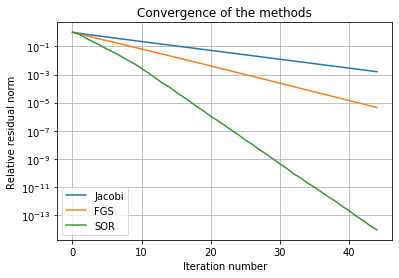

In [9]:
# Task i)

TOL = 1e-14

def plot_residual(M):  #Plotting the relative residual, returns the convergence speed ||x^(k+1)-L||/||x^k-L||
    iter_number = np.arange(M)
    rel_jac = np.zeros(M)
    rel_FGS = np.zeros(M)
    rel_sor = np.zeros(M)
    
    r0 = f - np.dot(Lap,guess)
    
    for k in iter_number:
        r_jac = f - np.dot(Lap,jacobiMethod(Lap,f,guess,k)[0])   #r^k = f-Au^k
        r_FGS = f - np.dot(Lap,gaussSeidel(Lap,f,guess,k)[0])
        r_sor = f - np.dot(Lap,sorMethod(Lap,f,guess,relax,k)[0])
        
        rel_jac[k] = np.linalg.norm(r_jac) / np.linalg.norm(r0)  #||r^k||/||r^0||
        rel_FGS[k] = np.linalg.norm(r_FGS) / np.linalg.norm(r0)
        rel_sor[k] = np.linalg.norm(r_sor) / np.linalg.norm(r0)
        
        
        
    
    
    
    
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.set(title='Convergence of the methods',xlabel='Iteration number',ylabel='Relative residual norm')
    ax.semilogy(iter_number, rel_jac, label='Jacobi')
    ax.semilogy(iter_number,rel_FGS,label='FGS')
    ax.semilogy(iter_number,rel_sor,label='SOR')
    ax.legend()
    plt.grid()
    
    return rel_jac[-1]/rel_jac[-2],rel_FGS[-1]/rel_FGS[-2],rel_sor[-1]/rel_sor[-2]  

plot_residual(45)









ii) Implement a stopping criterion for the three methods as you have done for the Newton method. Record the relative time each method takes per iteration, and the rime needed to obtain a norm of the relative residual below toleances  $TOL=1e-7$ and $TOL=1e-14$. Make a table with the results for each method.

In [10]:
# Timing runtime

TOL = 1e-7



time_jac = jacobiMethod(Lap,f,guess,1000)[2]        
iterNumb_jac = jacobiMethod(Lap,f,guess,1000)[1]
time_FGS = gaussSeidel(Lap,f,guess,100)[2]
iterNumb_FGS = gaussSeidel(Lap,f,guess,100)[1]
time_sor = sorMethod(Lap,f,guess,relax,100)[2]
iterNumb_sor = sorMethod(Lap,f,guess,relax,100)[1]

table=[["Jacobi Method",np.sum(time_jac),np.sum(time_jac)/iterNumb_jac,TOL],['Forward Gauss-Seidel Method',np.sum(time_FGS),
np.sum(time_FGS)/iterNumb_FGS,TOL],["Stress over relaxation",np.sum(time_sor),np.sum(time_sor)/iterNumb_sor,TOL]]

print(tab.tabulate(table,headers = ['Method', 'Total time to tolerance','Average time per iteration','Tolerance level']))



Method                         Total time to tolerance    Average time per iteration    Tolerance level
---------------------------  -------------------------  ----------------------------  -----------------
Jacobi Method                                0.0185427                   0.000157142              1e-07
Forward Gauss-Seidel Method                  0.0062566                   9.93111e-05              1e-07
Stress over relaxation                       0.002245                    8.63462e-05              1e-07


In [11]:
TOL=1e-14



time_jac = jacobiMethod(Lap,f,guess,1000)[2]        
iterNumb_jac = jacobiMethod(Lap,f,guess,1000)[1]
time_FGS = gaussSeidel(Lap,f,guess,100)[2]
iterNumb_FGS = gaussSeidel(Lap,f,guess,100)[1]
time_sor = sorMethod(Lap,f,guess,relax,100)[2]
iterNumb_sor = sorMethod(Lap,f,guess,relax,100)[1]




table2 =[["Jacobi Method",np.sum(time_jac),np.sum(time_jac)/iterNumb_jac,TOL],['Forward Gauss-Seidel Method',np.sum(time_FGS),
np.sum(time_FGS)/iterNumb_FGS,TOL],["Stress over relaxation",np.sum(time_sor),np.sum(time_sor)/iterNumb_sor,TOL]]


print(tab.tabulate(table2,headers = ['Method', 'Total time to tolerance','Average time per iteration','Tolerance level']))



Method                         Total time to tolerance    Average time per iteration    Tolerance level
---------------------------  -------------------------  ----------------------------  -----------------
Jacobi Method                                0.0364388                   0.000159121              1e-14
Forward Gauss-Seidel Method                  0.0097452                   9.7452e-05               1e-14
Stress over relaxation                       0.0037721                   8.02574e-05              1e-14


iii) Calculate the spectral radius of $A_1^{-1}A_2$ and see how that relates to convergence of the method. Make a semi-log plot for comparison. 

<div class="alert alert-block alert-info">
<b>Hint:</b> Python's 
    <pre>numpy.linalg.eigvals(A)</pre>
function returns the eigenvalues of $A$.
</div>

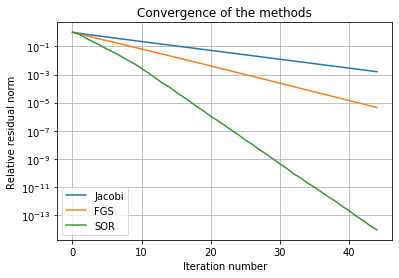

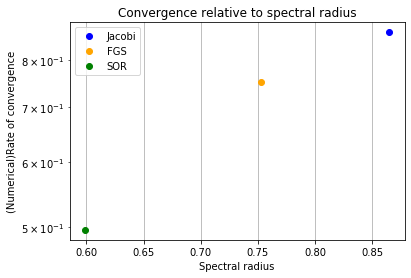

We see that as spectral radius decreases we get faster convergence, as we expect.


In [12]:
# Specral radii  

def printSpectral(A,w):  #Function that calculates the sprectral radii
    D = np.diag(A)*np.eye(N)
    U = np.triu(A) - D
    L = np.tril(A,-1)
    
    A1_j = D
    A2_j = A1_j - A
    
    Aj =np.abs( np.linalg.eigvals( np.dot( np.linalg.inv(A1_j), A2_j ) ) )
    
    A1_fgs = D + L
    A2_fgs = A1_fgs - A
    
    Afgs = np.abs( np.linalg.eigvals( np.dot( np.linalg.inv(A1_fgs), A2_fgs ) ) )
    
    A1_sor = D + w*L
    A2_sor = A1_sor - A
    
    Asor = np.abs( np.linalg.eigvals( np.dot( np.linalg.inv(A1_sor), A2_sor ) ) )
    
    
    return np.amax(Aj),np.amax(Afgs),np.amax(Asor)


#Plotting the 'limit' of rate of convergence versus the spectral radius


specList = printSpectral(Lap,relax)
relList = plot_residual(45)

fig = plt.figure()
ax = plt.subplot(111)
ax.set(xlabel='Spectral radius',ylabel='(Numerical)Rate of convergence',title='Convergence relative to spectral radius')
ax.semilogy(specList[0],relList[0],'bo',label='Jacobi')
ax.semilogy(specList[1],relList[1],'o',label='FGS',color='orange')
ax.semilogy(specList[2],relList[2],'go',label='SOR')
plt.grid()
ax.legend()
plt.show()

print('We see that as spectral radius decreases we get faster convergence, as we expect.')